# Single Object Classifier

The notebook illustrates how this synthetic data generator can help to create and test a single image classifier.

**Please note that the goal of this notebook is not to create the perfect ML model, but to demonstrate how to use the functionality of this library.**

In [1]:
import sys
sys.path.insert(0, '..')

from PIL import ImageDraw
import tensorflow as tf
import numpy as np

from squids import (
    create_dataset,
    create_tfrecords,
    explore_tfrecords,
    load_tfrecords,
    Palette,
    Background
)

from helper import plot_images

## Preparing Dataset

Generate synthetic dataset and convert it to TFRecords.

In [2]:
create_dataset(
    dataset_size=50000,
    image_palette=Palette.BINARY,
    image_background=Background.BLACK,
    random_state=365, image_capacity=1,
    verbose=True)
create_tfrecords(
    verbose=True)

100%|██████████| 5016/5016 [00:06<00:00, 747.82it/s] 


Explore 9 samples from the generated dataset.

2022-02-15 15:17:46.874674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 15:17:46.908832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 15:17:46.909255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 15:17:46.909865: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

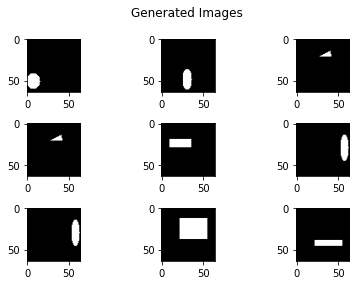

In [3]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_train',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_train',
        image_id,
        with_categories = False,
        with_bboxes = False,
        with_segmentations = False,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:10]
]

plot_images(images, "Generated Images")

## Train Object Classification Model

Let's create generators for train and validation datasets and compute steps per epoch for each of them.

In [4]:
import pathlib

ds_train, train_steps_per_epoch = load_tfrecords(
    pathlib.Path("dataset/synthetic-tfrecords/instances_train"), 
    output_schema = "C",
    num_detecting_objects=1,
    batch_size=128
)
print("Training steps per epoch (for the batch size 128): ", train_steps_per_epoch)

ds_val, val_steps_per_epoch = load_tfrecords(
    pathlib.Path("dataset/synthetic-tfrecords/instances_val"), 
    output_schema = "C",
    num_detecting_objects=1,
    batch_size=128
)
print("Validation steps per epoch (for the batch size 128): ", val_steps_per_epoch)

Training steps per epoch (for the batch size 128):  274
Validation steps per epoch (for the batch size 128):  79


In [5]:
for x,y in ds_train:
    print(y)
    break

tf.Tensor(
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]

Let's define a simple convolution model.

In [6]:
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(
			filters=32,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu'),
	tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
	metrics=tf.keras.metrics.CategoricalAccuracy()
)

Train the model.

In [7]:
model.fit(
    ds_train,
    steps_per_epoch = train_steps_per_epoch,
    epochs=10,
    validation_data=ds_val,
    validation_steps = val_steps_per_epoch,
    verbose=1
)

Epoch 1/10


2022-02-15 15:18:01.671362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-15 15:18:02.170725: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


274/274 [==============================] - 36s 123ms/step - loss: 1.4632 - categorical_accuracy: 0.4899 - val_loss: 0.8473 - val_categorical_accuracy: 0.5923
Epoch 2/10
274/274 [==============================] - 33s 122ms/step - loss: 0.6105 - categorical_accuracy: 0.7306 - val_loss: 0.3895 - val_categorical_accuracy: 0.8518
Epoch 3/10
274/274 [==============================] - 33s 121ms/step - loss: 0.2046 - categorical_accuracy: 0.9300 - val_loss: 0.2007 - val_categorical_accuracy: 0.9339
Epoch 4/10
274/274 [==============================] - 33s 121ms/step - loss: 0.0867 - categorical_accuracy: 0.9746 - val_loss: 0.1574 - val_categorical_accuracy: 0.9495
Epoch 5/10
274/274 [==============================] - 34s 123ms/step - loss: 0.0507 - categorical_accuracy: 0.9853 - val_loss: 0.1472 - val_categorical_accuracy: 0.9534
Epoch 6/10
274/274 [==============================] - 34s 124ms/step - loss: 0.0356 - categorical_accuracy: 0.9903 - val_loss: 0.1490 - val_categorical_accuracy: 0.95

## Test Object Classification Model

Let's test the model on the unseen data.

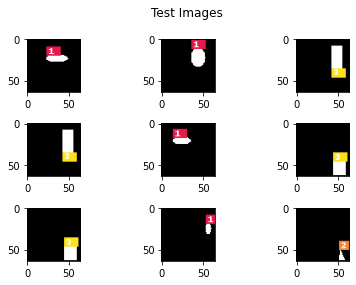

In [8]:
image_ids, y = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_test',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_test',
        image_id,
        with_categories = True,
        with_bboxes = False,
        with_segmentations = False,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:9]
]

plot_images(images, "Test Images")

In [9]:
preprocessed_images = np.array(
    [np.array(image) for image in images]
) / 255.0

predicted_onehots = model.predict(preprocessed_images)

In [10]:
x = np.argmax(predicted_onehots, axis=1)
x

array([1, 1, 1, 1, 3, 3, 2, 3, 2])

In [20]:
list(map(lambda x: list(x)[0], y[0:9]))

[1, 1, 3, 1, 3, 1, 2, 3, 3]

In [21]:
from sklearn.metrics import classification_report

ModuleNotFoundError: No module named 'sklearn'